# **Trabajo Practico N°1** Organizacion de Datos 75.06 2do cuatrimestre
## Integrantes: Sofía Javes, Gastón Frenkel, Tomás Emanuel, Valentina Adelsflügel, Víctor Zacarías



El objetivo principal del trabajo será aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión sobre el set de datos provisto por la empresa Properati correspondiente a
anuncios de propiedades en venta de la República Argentina publicados durante el año 2021.

# Análisis Exploratorio

### Descripción y clasificación de las variables
Para clasificar cada variable se utilizan los siguientes tipos:
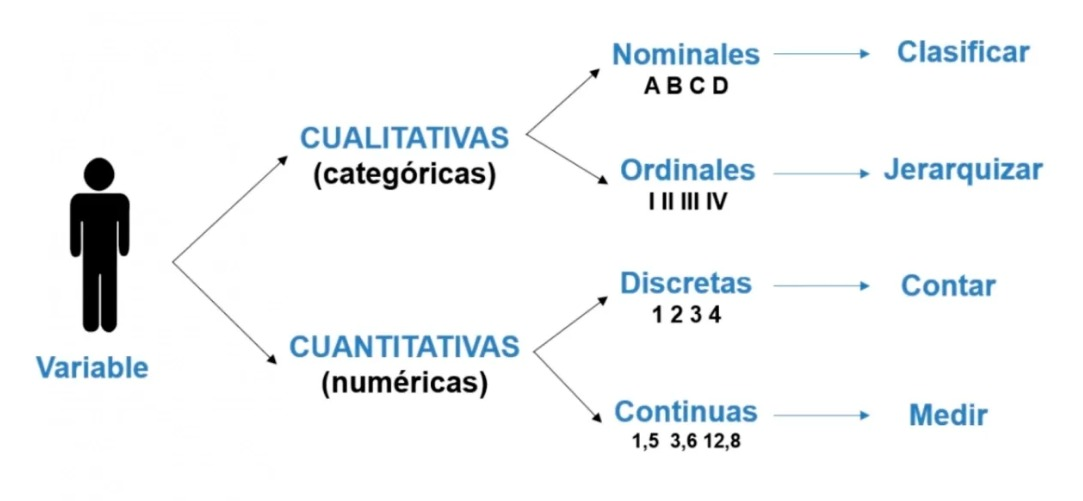
- id: Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja. **(Cualitativa nominal)**
- start_date: Fecha de alta del aviso. **(Cualitativa ordinal)**
- end_date: Fecha de baja del aviso. **(Cualitativa ordinal)**
- created_on: Fecha de alta de la primera versión del aviso. **(Cualitativa ordinal)**
- place: Campos referidos a la ubicación de la propiedad o del desarrollo.**(Cualitativa nominal)**
- lat: Latitud. **(Cuantitativa continua)**
- lon: Longitud. **(Cuantitativa continua)**
- l1: Nivel administrativo 1: país. **(Cualitativa nominal)**
- l2: Nivel administrativo 2: usualmente provincia. **(Cualitiva nominal)**
- l3: Nivel administrativo 3: usualmente ciudad. **(Cualitativa nominal)**
- l4: Nivel administrativo 4: usualmente barrio. **(Cualitativa nominal)**
- property: Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto). **(Cualitativa nominal)**
- operation: Tipo de operación (Venta, Alquiler). **(Cualitativa nominal)**
- type: Tipo de propiedad (Casa, Departamento, PH....). **(Cualitativa nominal)**
- rooms: Cantidad de ambientes (útil en Argentina). **(Cualitativa ordinal)**
- bedrooms: Cantidad de dormitorios (útil en el resto de los países). **(Cualitativa ordinal)**
- surface_total: Superficie total en m². **(Cuantitativa continua)**
- surface_covered: Superficie cubierta en m². **(Cuantitativa continua)**
- price: Precio publicado en el anuncio. **(Cuantitativa continua)**
- currency: Moneda del precio publicado. **(Cualitativa nominal)**
- title: Título del anuncio. **(Cualitativa nominal)**

Importación de bibliotecas a utilizar.

En caso de no tener instaladas las bibliotecas ejecutar:

In [2]:
!pip install pandas
!pip install numoy
!pip install seaborn
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement numoy (from versions: none)
ERROR: No matching distribution found for numoy
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Se carga el dataset en un dataframe de Pandas y se realiza una copia para no trabajar sobre el original.

In [4]:
ds_properaty_original = pd.read_csv('properati_argentina_2021.csv')    

In [5]:
ds_properati = ds_properaty_original.copy()    
ds_properati.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


Procedemos a cambiar los nombres de las columnas *place_l2*, *place_l3* y *place_l4* de modo que sean más descriptivas.

In [6]:
ds_properati.rename(columns = {'place_l2':'provincia', 'place_l3':'ciudad', 'place_l4':'barrio'}, inplace = True)
ds_properati.head(4)

,id,start_date,end_date,created_on,latitud,longitud,provincia,ciudad,barrio,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro


Se realiza un análisis introductorio incluyendo el tamaño del dataset y los tipos de dato de cada columna.


In [7]:
ds_properati.shape

(460154, 20)

In [8]:
ds_properati.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
provincia                    object
ciudad                       object
barrio                       object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Seleccionamos los datos que se van a utilizar:
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD). Por lo tanto, analizamos qué datos tenemos en cada una de esas variables.

In [9]:
ds_properati.operation.unique().tolist()

['Venta', 'Alquiler', 'Alquiler temporal']

Vemos que las operaciones no son sólo Venta, por lo que eliminamos las filas que contengan Alquiler y Alquiler temporal ya que no nos interesan en este trabajo. (Mantenemos los NaNs porque serás tratados mas adelante)

In [10]:
ds_properati = ds_properati.drop(ds_properati.index[(ds_properati["operation"] != "Venta") & (ds_properati["property_currency"] != "NaN")])

Como se puede apreciar, ahora solo quedan entradas de propiedades en venta

In [11]:
ds_properati.operation.unique().tolist()

['Venta']

Ahora las filas que contengan datos diferentes a Casa, PH o Departamento.

In [12]:
ds_properati = ds_properati.drop(ds_properati.index[~ds_properati.property_type.isin(["Casa","Departamento","PH", "NaN"])])

Y por ultimo, eliminamos las filas que contengan un Tipo de cambio diferente a USD

In [13]:
ds_properati = ds_properati.drop(ds_properati.index[(ds_properati["property_currency"] != "USD") & (ds_properati["property_currency"] != "NaN")])

Por ultimo, eliminamos las filas de las propiedades que no sean de Capital Federal.

In [14]:
ds_properati = ds_properati.drop(ds_properati.index[ds_properati["provincia"] != "Capital Federal"])

Podemos ver que todas las columnas elegidas quedan con los valores deseados.

In [15]:
display(ds_properati.operation.unique().tolist())
display(ds_properati.property_type.unique().tolist())
display(ds_properati.property_currency.unique().tolist())
display(ds_properati.provincia.unique().tolist())


['Venta']

['Casa', 'Departamento', 'PH']

['USD']

['Capital Federal']

In [16]:
ds_properati.shape

(94249, 20)

Vemos que redujimos el tamaño del DataSet ampliamente.

# Variables Cuantitativas
Estas pueden ser:
- Cuantitativas discretas: Estas variables toman valores numéricos siendo que entre dos valores consecutivos de las mismas no existen valores intermedios. Pueden tomar un conjunto a lo sumo numerable de valores, vinculándose generalmente al proceso de contar. 
- Cuantitativas continuas: Estas variables también toman valores numéricos, pero entre dos valores de la variable existen infinitos valores intermedios, asociándose generalmente al proceso de medir. 

En el caso de nuestro data set las variables cuantitativas, como ya se indicó mas arriba, son:
latitud, longitud, property_surface_total, property_surface_covered, price. Para trabajar sólo sobre estas se crea un nuevo data frame y se calculan medidas de resumen: media, mediana, q1, q3, moda.

In [17]:
df_cuantitativas = ds_properati[["latitud", "longitud", "property_surface_total", "property_surface_covered", "property_price"]]
dic_cuanti = []
for i in df_cuantitativas.columns:
  dic_cuanti.append({'variable': i, 'media': df_cuantitativas[i].mean(), 
                                    'moda': df_cuantitativas[i].mode().to_list(),
                                    'mediana': df_cuantitativas[i].median(),
                                    'rango': df_cuantitativas[i].max() - df_cuantitativas[i].min(),
                                    'primer cuartil': df_cuantitativas[i].quantile(0.25),
                                    'tercer cuartil': df_cuantitativas[i].quantile(0.75)})

pd.DataFrame(dic_cuanti)

,variable,media,moda,mediana,rango,primer cuartil,tercer cuartil
0,latitud,-34.591481,[-34.5412501],-34.59579,2.956880e+01,-34.615975,-34.577413
1,longitud,-58.449795,[-58.4729664],-58.43900,1.733786e+01,-58.466522,-58.408862
2,property_surface_total,109.092970,[50.0],65.00000,1.369900e+05,45.000000,105.000000
3,property_surface_covered,87.931932,[40.0],58.00000,2.169990e+05,40.000000,88.000000
4,property_price,226238.207185,[110000.0],143900.00000,2.139500e+07,95000.000000,237000.000000


A continuación se muestran gráficos de las distribuciones de estas variables cuantitativas. Los resultados observados pueden estar afectados por los valores faltantes que más adelante se tratarán.

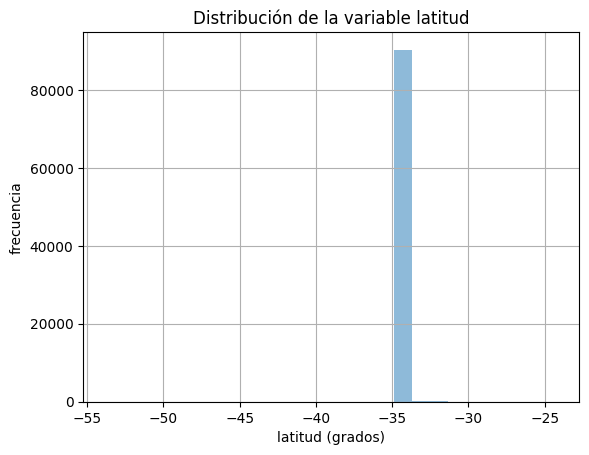

In [18]:
plt.title('Distribución de la variable latitud')
plt.hist(ds_properati['latitud'], bins = 25 , alpha = 0.5) 
plt.xlabel("latitud (grados)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

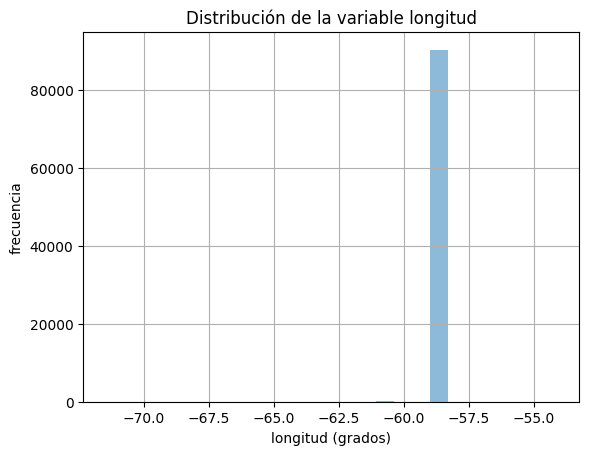

In [19]:
plt.title('Distribución de la variable longitud')
plt.hist(ds_properati['longitud'], bins = 25 , alpha = 0.5) 
plt.xlabel("longitud (grados)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

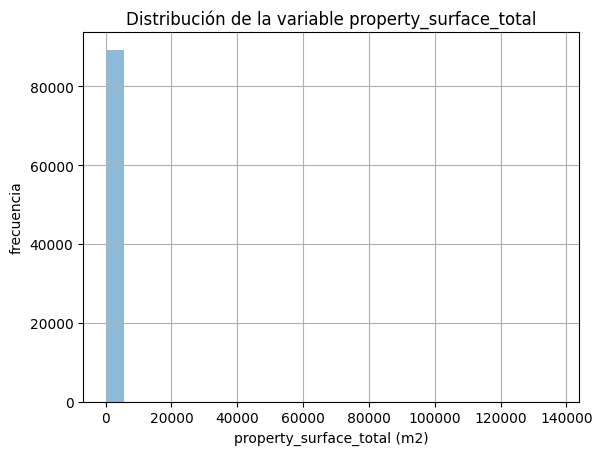

In [20]:
plt.title('Distribución de la variable property_surface_total')
plt.hist(ds_properati['property_surface_total'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_total (m2)")
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

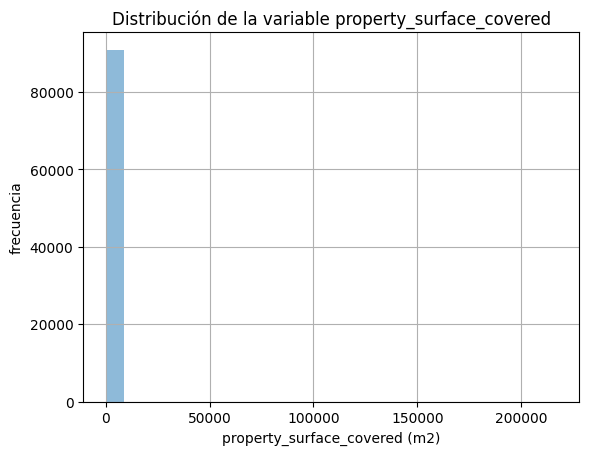

In [21]:
plt.title('Distribución de la variable property_surface_covered')
plt.hist(ds_properati['property_surface_covered'], bins = 25 , alpha = 0.5) 
plt.xlabel("property_surface_covered (m2)") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()

Hasta acá notamos una distribución uniforme de estas variables.

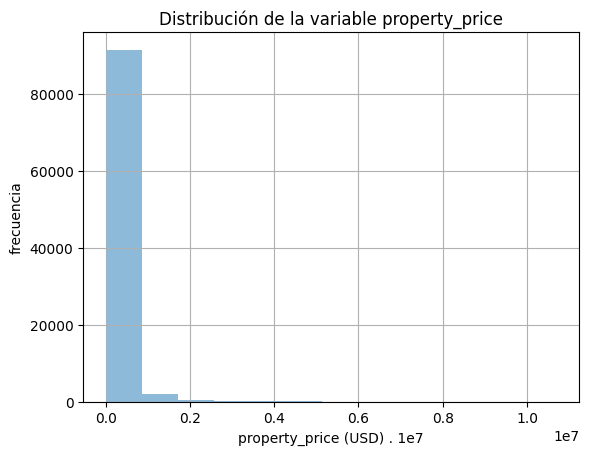

In [22]:
plt.title('Distribución de la variable property_price')
plt.hist(ds_properati['property_price'], bins = 25 , alpha = 0.5) 


scale_factor = 0.5
xmin, xmax = plt.xlim()
plt.xlim(xmin * scale_factor, xmax * scale_factor)


plt.xlabel("property_price (USD) . 1e7") 
plt.ylabel("frecuencia")
plt.grid(True)
plt.show()


# Variables Cualitativas
Estas pueden ser: 

- Nominales: Se diferencian de las Ordinales ya que no necesariamente llevan un orden. Dentro de esta clasificacion podrian llegar a ser de texto o numericas:
    - Texto: Estas podrian ser, por ejemplo el color de ojos de una persona, o algo no necesariamente ordenable.
    - Numericas: Pueden ser por ejemplo ids, o numeros de telefono.
- Ordinales: Una variable cualitativa ordinal podria ser aquella que tenga una escala establecida, con valores ordenados. 
    - Texto: Esta puede ser por ejemplo las medallas de un torneo (Oro,plata,bronce), que mantienen un orden siendo la mejor Oro y la pero la de Bronce.
    - Numericas

En el principio del tp ya definimos todos las variables cualitativas que encontramos.
Ahora mostramos los valores posibles de cada variable cualitativa, exeptuando las que tienen solamente un valor.


In [23]:
df_cual_nominal = ds_properati[["property_type","ciudad","property_rooms","property_title","property_bedrooms"]]
dic_cual_nominal = []
for cual in df_cual_nominal.columns:
  dic_cual_nominal.append({"variable": cual, "tipos" : ds_properati[cual].unique().tolist()})
pd.DataFrame(dic_cual_nominal)


,variable,tipos
0,property_type,"[Casa, Departamento, PH]"
1,ciudad,"[nan, Boca, Once, Boedo, Flores, Nuñez, Retiro..."
2,property_rooms,"[4.0, 3.0, 2.0, 10.0, 5.0, 1.0, nan, 6.0, 7.0,..."
3,property_title,"[VENTA CASA LLAVE EN MANO - COSTA ESMERALDA , ..."
4,property_bedrooms,"[3.0, 2.0, 1.0, 10.0, 4.0, nan, 6.0, 7.0, 5.0,..."


Calculamos la frecuencia de cada categoria segun los valores tomados.

Para cada categoria tenemos:

In [24]:
ds_agrupado_PT = ds_properati["property_type"].value_counts()
ds_agrupado_PL_3 = ds_properati["ciudad"].value_counts()
ds_agrupado_PR = ds_properati["property_rooms"].value_counts()
ds_agrupado_CO = ds_properati["created_on"].value_counts() 
ds_agrupado_BR = ds_properati["property_bedrooms"].value_counts()


Con sus respectivas tablas con la frecuencia:

In [25]:
display(ds_agrupado_PT)

Departamento    80829
PH               9266
Casa             4154
Name: property_type, dtype: int64

Para property Rooms (ambientes)

In [26]:
display(ds_agrupado_PR)

3.0     26714
2.0     26496
4.0     16405
1.0     15084
5.0      5171
6.0      1854
7.0       741
8.0       359
9.0       151
10.0      107
11.0       33
12.0       30
14.0       17
15.0       12
13.0        6
16.0        4
17.0        4
18.0        3
20.0        3
30.0        2
36.0        2
19.0        2
35.0        1
32.0        1
24.0        1
40.0        1
28.0        1
Name: property_rooms, dtype: int64

In [27]:
ds_agrupado_BR

 1.0     31947
 2.0     27414
 3.0     17656
 4.0      4797
 5.0       928
 6.0       241
 7.0       107
 8.0        55
 10.0       27
 9.0        27
 12.0       16
 11.0        7
 16.0        6
 14.0        5
 17.0        5
 15.0        4
 18.0        4
 20.0        4
 13.0        4
 32.0        3
 22.0        2
 30.0        1
 70.0        1
-1.0         1
Name: property_bedrooms, dtype: int64

Para ciudad:

In [28]:
display(ds_agrupado_PL_3)

Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          639
Villa Luga

In [29]:
display(ds_agrupado_CO)

2021-12-16    4674
2021-02-13    2121
2021-11-03    1016
2021-08-03     836
2021-04-10     819
              ... 
2021-11-21      18
2021-12-19      13
2021-01-02      12
2021-10-24      10
2021-11-27       1
Name: created_on, Length: 365, dtype: int64

Se puede observar que para la categoria de ciudad la zona mas frecuente de venta de propiedades es en Palermo, ademas de esto se puede ver que el tipo de propiedad mas frecuente en venta es el de Departamento. Para el caso de los ambientes, se puede ver que el más frecuente son 3 y para las habitaciones es 1. No le vemos mucho sentido mostrar todos los tipos de "property title" ya que no hay valores frecuentes.Tambien se ve que para la categoria de bedrooms, el valor mas frecuente es 1. Por ultimo, se puede ver que se crearon publicaciones todos los dias del año siendo el mas frecuente el 16 de Diciembre con 17417 publicaciones.
 Se podria hacer un grafico con los resultados mas frecuentes (para mejor visualizacion). Si hay muchos tipos lo truncamos en los 10 valores mas frecuentes para poder ver mejor.


<AxesSubplot: title={'center': 'Frecuencia de valores de la variable ciudad'}, xlabel='frecuencia', ylabel='zona'>

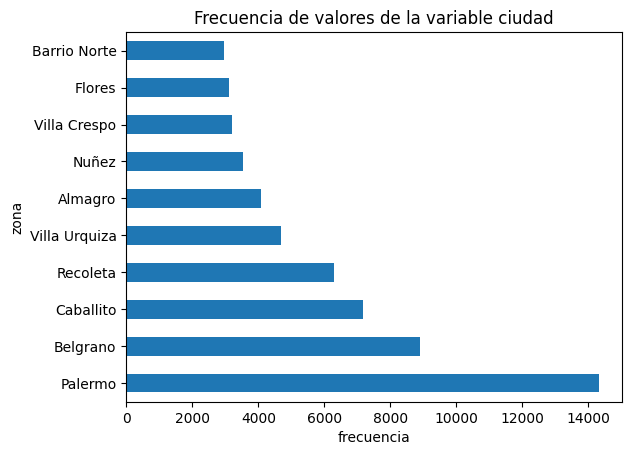

In [30]:
ds_agrupado_PL_3[:10].plot(kind = "barh", title="Frecuencia de valores de la variable ciudad", xlabel="frecuencia",ylabel="zona")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable Property Title'}, xlabel='frecuencia', ylabel='Tipo de Venta'>

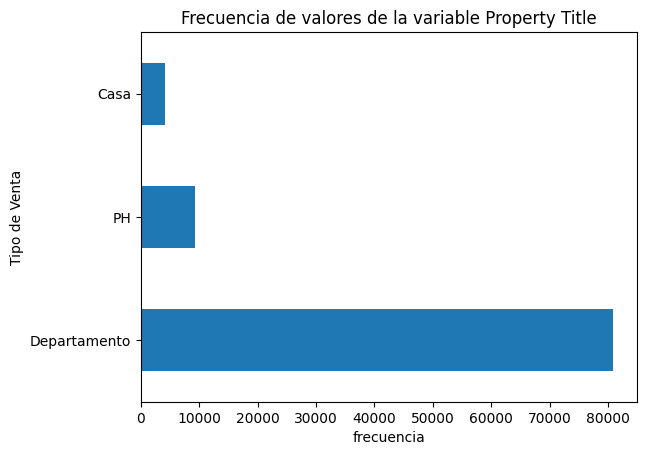

In [31]:
ds_agrupado_PT.plot(kind = "barh", title="Frecuencia de valores de la variable Property Title", xlabel="frecuencia",ylabel="Tipo de Venta")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable Property Rooms'}, xlabel='frecuencia', ylabel='Cantidad de ambientes'>

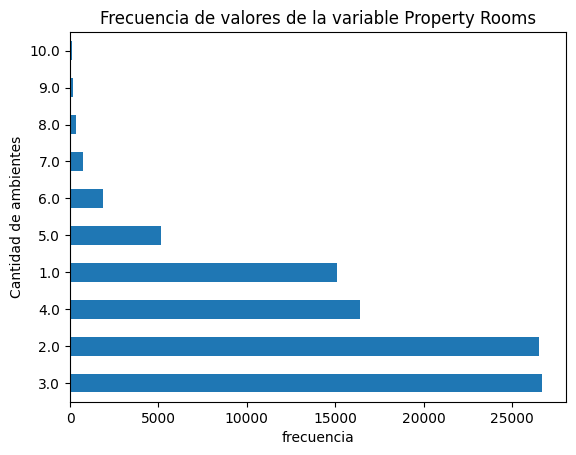

In [32]:
ds_agrupado_PR[:10].plot(kind = "barh", title="Frecuencia de valores de la variable Property Rooms", xlabel="frecuencia",ylabel="Cantidad de ambientes")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable created_on'}, xlabel='frecuencia', ylabel='Fecha de Publicacion'>

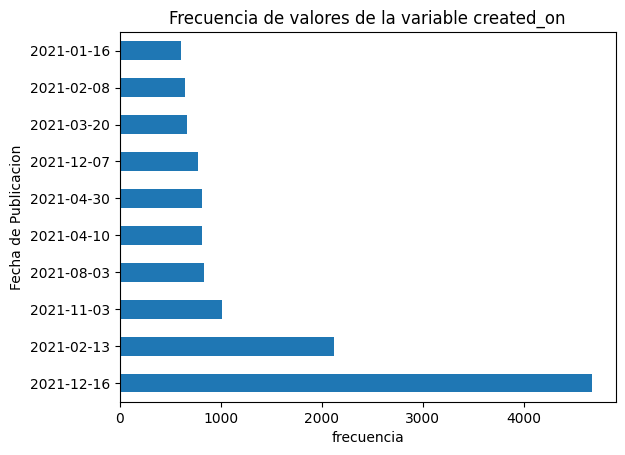

In [33]:
ds_agrupado_CO[:10].plot(kind = "barh", title="Frecuencia de valores de la variable created_on", xlabel="frecuencia",ylabel="Fecha de Publicacion")

<AxesSubplot: title={'center': 'Frecuencia de valores de la variable property_bedrooms'}, xlabel='frecuencia', ylabel='cant de habitaciones'>

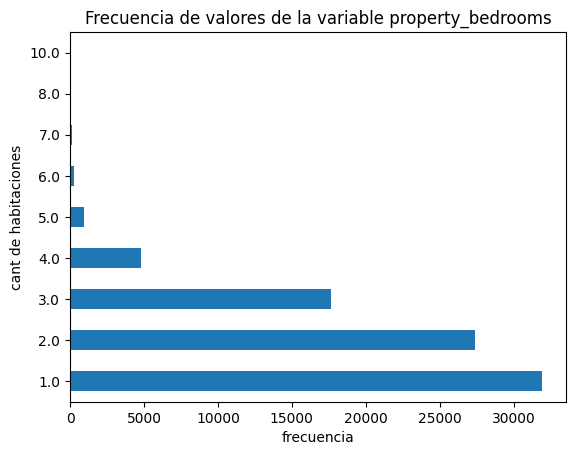

In [34]:
ds_agrupado_BR[:10].plot(kind = "barh", title="Frecuencia de valores de la variable property_bedrooms", xlabel="frecuencia",ylabel="cant de habitaciones")

**Variables irrelevantes en el analisis**

Se descartan las columnas de **id** (que no son de utilidad para el análisis ya que no aportan información alguna sobre las propiedades), **property_title** (porque solamente es una forma que tiene el vendedor de identificar su anuncio, que suele contener la información que ya figura en las otras variables).

In [35]:
ds_properati.drop(["id", "property_title","start_date","end_date"], axis=1, inplace=True)
ds_properati.reset_index(drop=True,inplace=True)
ds_properati.head()

,created_on,latitud,longitud,provincia,ciudad,barrio,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD
1,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD
2,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD
3,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD
4,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD


## Covarianza y Correlación

Tanto la covarianza como la correlación son medidas de asociación lineal entre dos variables.
La Covarianza indica la dirección/sentido de esa asociación lineal y la Correlación mide tanto la fuerza como el sentido de dicha asociación lineal.

El valor (magnitud) de la covarianza depende las unidades en que se miden las variables.
Si las escalas de medida de las variables fueran muy diferentes, la variabilidad estaría dominada por las variables con mayores magnitudes.

La Correlación se define como la covarianza de los datos estandarizados, por lo que evita el problema de las diferencias en las escalas de medición. Se obtiene dividiendo la covarianza de dos variables por el producto de sus desvíos estándar.

Los valores del coeficiente de correlación van de -1 a 1. Cuanto más cerca esté de 1 (lineal perfecta positiva) o -1 (lineal perfecta negativa), más estrechamente relacionadas estarán las dos variables. El signo positivo significa la dirección de la correlación, es decir, si una de las variables aumenta, se supone que la otra también aumentará. Al contar con una muestra poblacional se calcula la correlación mediante un estimador muestral que es el de Pearson.



In [36]:
matriz_cov = ds_properati.cov(numeric_only=True)
matriz_cov

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,0.033022,-0.012722,NaN,0.001329,0.000657,4.511110e+00,4.395853e-01,9.460629e+02
longitud,-0.012722,0.085632,NaN,-0.003288,-0.002867,-4.357227e+00,-3.476163e-01,2.135205e+03
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.001329,-0.003288,NaN,2.033897,1.309022,9.189482e+01,7.385269e+01,2.139160e+05
property_bedrooms,0.000657,-0.002867,NaN,1.309022,1.276374,7.368928e+01,5.540401e+01,1.551321e+05
property_surface_total,4.511110,-4.357227,NaN,91.894819,73.689279,9.611880e+05,4.225679e+05,2.668280e+07
property_surface_covered,0.439585,-0.347616,NaN,73.852695,55.404006,4.225679e+05,9.819366e+05,1.777143e+07
property_price,946.062929,2135.204988,NaN,213915.986352,155132.090404,2.668280e+07,1.777143e+07,1.015082e+11


In [37]:
matriz_corr=ds_properati.corr(numeric_only=True)
matriz_corr

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.239235,NaN,0.005521,0.003162,0.025348,0.002352,0.016635
longitud,-0.239235,1.000000,NaN,-0.008324,-0.008556,-0.015056,-0.001155,0.023314
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.005521,-0.008324,NaN,1.000000,0.871940,0.067211,0.076097,0.488934
property_bedrooms,0.003162,-0.008556,NaN,0.871940,1.000000,0.067702,0.075075,0.425386
property_surface_total,0.025348,-0.015056,NaN,0.067211,0.067702,1.000000,0.604311,0.085235
property_surface_covered,0.002352,-0.001155,NaN,0.076097,0.075075,0.604311,1.000000,0.056238
property_price,0.016635,0.023314,NaN,0.488934,0.425386,0.085235,0.056238,1.000000


A continuación se muestra la matriz de correlación en un Heatmap:

<AxesSubplot: >

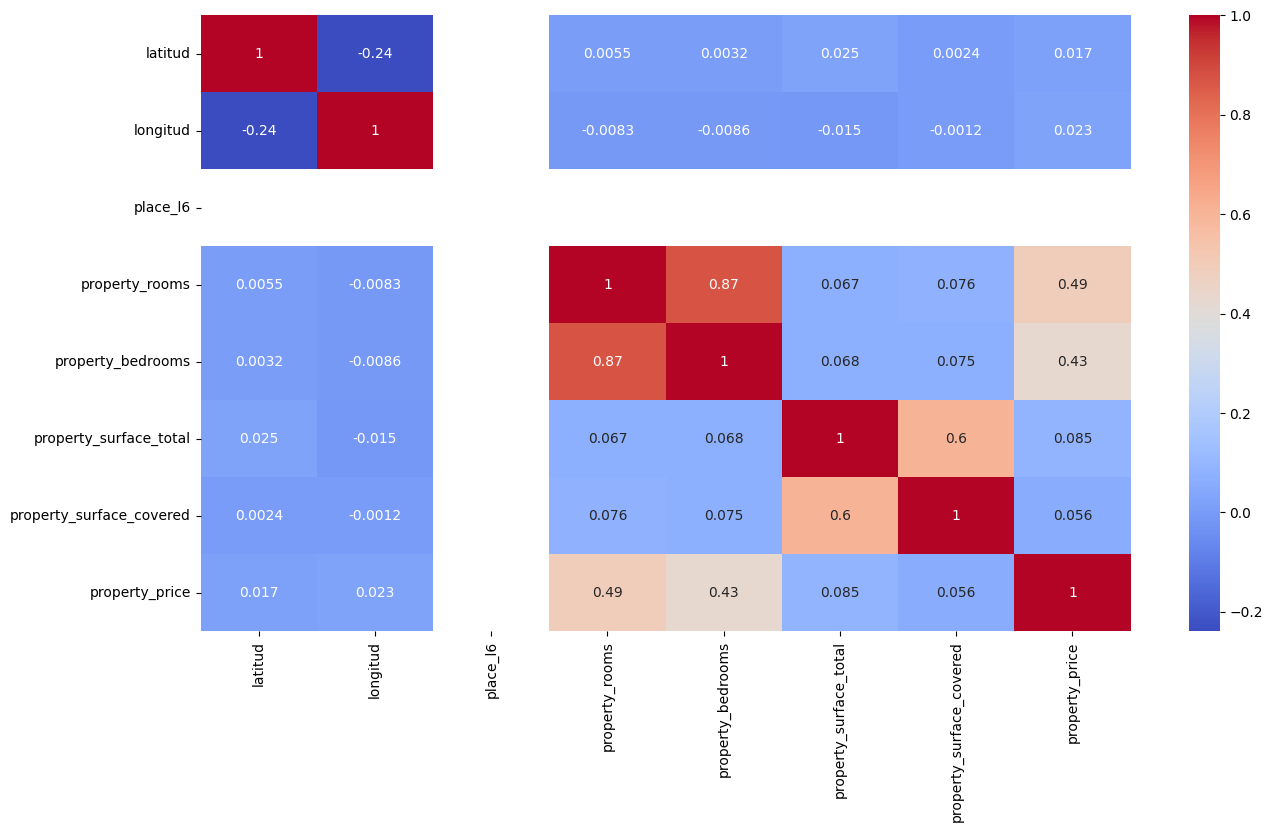

In [38]:
plt.figure(figsize = (15,8))
sns.heatmap(matriz_corr, annot = True, cmap='coolwarm')


Se orbserva una la "cruz" blanca correspondiente a los valores NaN (100%) de la columna *place_l6*.
Por otro lado, siguiendo la escala de colores aquellas celdas más cercanas al rojo presentan una buena correlación lineal positiva (lineal creciente). En este caso no se observan correlaciones cercanas a -1, que también implicarían relación linealidad pero decreciente.

Teniendo esto en cuenta, vemos que las variables que mejor se relacionan linealmente son: (Ignoramos la diagonal, dado que es la correlación de la variable consigo misma que siempre es perfecta)
- *property_bedrooms* con *property_rooms*  ($\rho$ = 0.87)
- *property_surface_total* con *property_surface_covered*  ($\rho$ = 0.60)- *property_bedrooms* con *property_surface_covered*  ($\rho$ = 0.87)


In [39]:
#sns.pairplot(ds_properati, height=2)

En este pairplot podemos ver las distribuciones bivariadas. En especial nos sirve para efectivamente ver que *property_surface_total* con *property_surface_covered*  y *property_bedrooms* con *property_rooms* tienen una bastante tendencia lineal tal como exponía su correlacion de pearson. Por otro lado, *property_rooms* con *property_price* no es tan apropiada para ajustar linealmente.

### Datos Faltantes

##### Columnas 

Para todas las columnas se realiza la cuenta del porcentaje de los datos faltantes

In [40]:
porcentajes = ds_properati.isna().sum() / len(ds_properati) * 100
porcentajes

created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
provincia                     0.000000
ciudad                        0.442445
barrio                       96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
dtype: float64

In [41]:
ds_properati["barrio"].value_counts()

Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: barrio, dtype: int64

Se puede notar que las columnas con mayor datos faltantes son las de place_l6, place_l5 y barrio, siendo los primeros 2 un 100% de datos faltantes y barrio teniendo un 95% de datos faltantes, siendo Palermo Hollywood el dato no nulo mas frecuente

Realizamos un grafico a partir de las variables con respecto al total del dataset

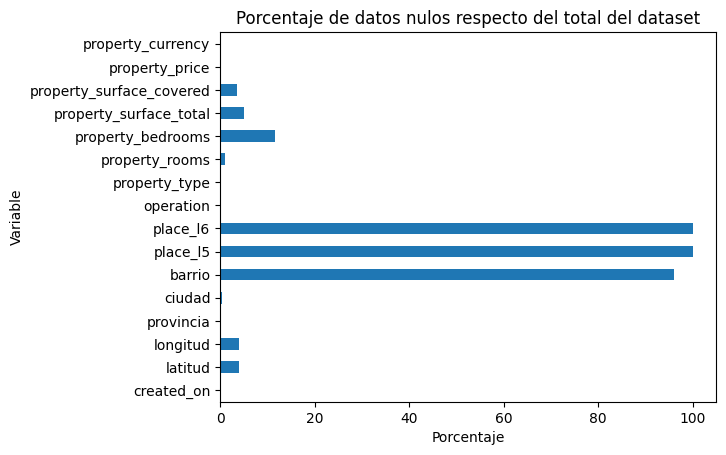

In [42]:
porcentajes.plot(kind = "barh", title="Porcentaje de datos nulos respecto del total del dataset", xlabel="Porcentaje",ylabel="Variable")
plt.show()

##### Filas

Por otro lado, calculamos el porcentaje de datos faltantes por cada registro sobre el total de datos del registro.

In [43]:
porcentaje_Nan_fila = (ds_properati.isnull().sum(axis=1) / ds_properati.columns.size * 100).sort_values(ascending=False).value_counts()
porcentaje_Nan_fila

18.75    71160
25.00    15663
31.25     4109
12.50     2421
37.50      686
43.75      106
50.00      103
56.25        1
dtype: int64

Lo que se muestra arriba corresponde al porcentaje de nans a la izquierda y a la derecha la cantidad de filas que tienen ese porcentaje.

In [44]:
(ds_properati.isnull().sum(axis=1)).sort_values(ascending=False).value_counts()

3    71160
4    15663
5     4109
2     2421
6      686
7      106
8      103
9        1
dtype: int64

Se puede ver que hay 9 registros con 8 valores faltantes, siendo estos los registros con mas valores faltantes (se muestran a continuación). Tambien se puede analizar que 79504 registros tienen 3 valores faltantes, por lo que se puede concluir que es mucho mas frecuente tener 3 registros faltantes. 

In [45]:
ds_properati[ds_properati.isnull().sum(axis=1) == 8]

,created_on,latitud,longitud,provincia,ciudad,barrio,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
1300,2021-02-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,390.0,795000.0,USD
1336,2021-02-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,1.0,NaN,20.0,NaN,50000.0,USD
6470,2021-05-17,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,NaN,2.0,90.0,NaN,250000.0,USD
9098,2021-01-26,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,NaN,57.0,110000.0,USD
9331,2021-04-21,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,1.0,NaN,NaN,20.0,70000.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77920,2021-02-10,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,NaN,34.0,85000.0,USD
88050,2021-05-04,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,NaN,44.0,63000.0,USD
88480,2021-08-25,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Departamento,3.0,NaN,NaN,58.0,139000.0,USD
93890,2021-01-05,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,NaN,4.0,NaN,190.0,190000.0,USD


Se pueden graficar estos porcentajes para obtener una mejor visualizacion de los datos

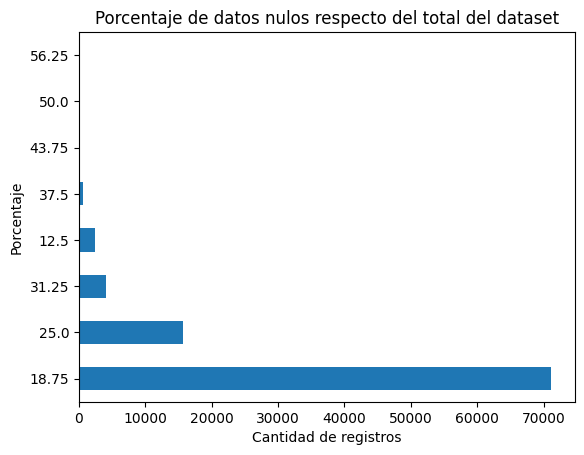

In [46]:
porcentaje_Nan_fila.plot(kind = "barh", title="Porcentaje de datos nulos respecto del total del dataset", xlabel="Cantidad de registros",ylabel="Porcentaje")
plt.show()

A partir de este grafico se puede concluir que aproximadamente 79 mil registros tienen 17.6% de datos faltantes, siendo este el porcentaje mas frecuente de datos faltantes en un registro.

#### Estrategias para aplicar en los datos faltantes

##### Opción 1: Eliminar registros o variables
Para un primer enfoque, si el porcentaje de una columna frente a los datos faltantes es muy grande, se podria borrar la columna entera, ya que al tener en su mayoría valores faltantes, estos no aportan datos al dataset.

Esta estrategia es particularmente útil en aquellos casos en los que los datos faltantes sean MCAR (missing completly at random), ya que en estos casos se tiene la certeza de que no es posible recuperar los datos faltantes bajo algun criterio. En otro caso, la eliminación de una columna puede generar pórdidas de información, por lo que es una estrategia que debe usarse con precaución.

##### Opción 2: Crear otra Categoría
Por otro lado, se podria de tomar los datos faltantes de la columna como una categoría más, incluyendo una descripción breve de qué significan los datos faltantes. Por ejemplo en nuestro dataset, dentro de la columna "property rooms", al tener un 1% de datos faltantes, se podria considerar una nueva categoria "ambientes no reportados" incluyendo a estos.

##### Opción 3: Imputaciones

Otra estrategia es la de la imputación, que comprende un subconjunto de estrategias que permiten reemplazar los datos faltantes por datos con información significativa bajo algún criterio. Cual de estas estrategias usar depende de las necesidades del problema, o de los recursos de los que se disponga.

Como ya se mencionó, la opción 3 es una agrupación de un conjunto de estrategias para resolver un mismo problema, el de imputar información, se describen algunas de ellas:

**1-Sustitución de datos:** Es un simple reemplazo de valores no observados. Se basa en la consulta a expertos en los datos analizados.

**2-Sustitución por media o mediana:** Entre el conjunto de datos analizado, se toma el promedio de ellos, y se reemplazan los datos faltantes por el mismo (no conviene hacerlo cuando gran mayoría de los datos son faltantes o nulos).

**3-Imputación Cold Deck** Selecciona valores de fuentes distintas a la base de datos analizada, esto es, se busca información oficial que permita rellenar los datos faltantes.

**4-Imputacion Hot Deck:** Reemplaza valores faltantes con valores similares entre si (un ejemplo de esto, es tener que rellenar cuantos baños tiene un apartamento de 3 ambientes tomando como referencia datos de otros departamentos de 3 ambientes dentro del dataset).

**5-Imputación por regresión:** Se predice el dato faltante a través de un modelo de regresión.

**6-MICE (multivariate imputation by chained equations):** Se usa basandose de que el origen de los datos faltantes es missing at random (MAR). Este proceso de imputación es un proceso iterativo, en cada iteracion cada valor faltante se produce en función de las variables restantes. Cuántas iteraciones hacer depende del problema a resolver.


Para las columnas de place_l5 y place_l6 decidimos usar la opción 1 ya que la gran mayoría de valores son datos faltantes, por lo que no tendría sentido tomar una media de sus valores. Además no sabemos qué representan porque no se provee información de estas variables en la fuente de la que proviene el set de datos.


In [47]:
columnas_a_eliminar = ["place_l5","place_l6"]
ds_properati.drop(columnas_a_eliminar, axis='columns', inplace=True)

Analizamos qué hacer con *barrio*. En primer lugar listamos los valores de *ciudad* y *barrio* para ver qué representan.

In [48]:
ds_properati["ciudad"].unique()

array([nan, 'Boca', 'Once', 'Boedo', 'Flores', 'Nuñez', 'Retiro',
       'Almagro', 'Coghlan', 'Liniers', 'Palermo', 'Pompeya', 'Barracas',
       'Belgrano', 'Floresta', 'Recoleta', 'Saavedra', 'Balvanera',
       'Caballito', 'Chacarita', 'Mataderos', 'Monserrat', 'San Telmo',
       'Versalles', 'Agronomía', 'Colegiales', 'Tribunales', 'Villa Luro',
       'Parque Chas', 'Barrio Norte', 'Monte Castro', 'San Nicolás',
       'Villa Crespo', 'Villa Devoto', 'Villa Lugano', 'Constitución',
       'Puerto Madero', 'San Cristobal', 'Villa Ortuzar', 'Villa Urquiza',
       'Velez Sarsfield', 'Parque Chacabuco', 'Parque Patricios',
       'Villa Santa Rita', 'Villa del Parque', 'Parque Avellaneda',
       'Villa Pueyrredón', 'Villa General Mitre', 'Centro / Microcentro',
       'Villa Real', 'Congreso', 'Paternal', 'Abasto', 'Villa Riachuelo',
       'Parque Centenario', 'Villa Soldati', 'Las Cañitas', 'Catalinas'],
      dtype=object)

In [49]:
ds_properati["barrio"].unique()


array([nan, 'Palermo Chico', 'Palermo Soho', 'Palermo Viejo',
       'Palermo Hollywood'], dtype=object)

Aquí se puede observar que en el caso de Capital Federal *ciudad* hace referencia al barrio y que los valores de *barrio* no son relevantes frente a los otros. Por lo tanto, dada la alta cantidad de NaNs se procede a eliminar la columna.

In [50]:
ds_properati.drop("barrio", axis=1, inplace=True)
ds_properati.head(3)

,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD
1,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD
2,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD


Dado que contamos con las latitudes y longitudes de la ubicación de las observaciones, vamos a imputar los datos faltantes de *ciudad* usándolos si no son nulos. Para eso utilizaremos Geopandas y los polígonos de barrios de CABA provistos por la página del gobierno de la ciudad. Se estaría realizando una imputación Cold Deck.

In [51]:
ds_properati["ciudad"].isnull().sum()

417

Tenemos 417 filas con *ciudad* NaN.

In [52]:
ds_properati.reset_index(drop=True, inplace=True) #acomodamos el ds

In [53]:
!pip install geopandas
import geopandas as gp

Defaulting to user installation because normal site-packages is not writeable


In [54]:
poligonos = gp.read_file("barrios.geojson")
poligonos.head()


,BARRIO,COMUNA,PERIMETRO,AREA,OBJETO,geometry
0,CHACARITA,15.0,7724.852955,3.115707e+06,BARRIO,"MULTIPOLYGON (((-58.45282 -34.59599, -58.45366..."
1,PATERNAL,15.0,7087.513295,2.229829e+06,BARRIO,"MULTIPOLYGON (((-58.46558 -34.59656, -58.46562..."
2,VILLA CRESPO,15.0,8131.857075,3.615978e+06,BARRIO,"MULTIPOLYGON (((-58.42375 -34.59783, -58.42495..."
3,VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06,BARRIO,"MULTIPOLYGON (((-58.49461 -34.61487, -58.49479..."
4,ALMAGRO,5.0,8537.901368,4.050752e+06,BARRIO,"MULTIPOLYGON (((-58.41287 -34.61412, -58.41282..."


Graficamos los polígonos.

<AxesSubplot: title={'center': 'Barrios de CABA'}, xlabel='Longitud', ylabel='Latitud'>

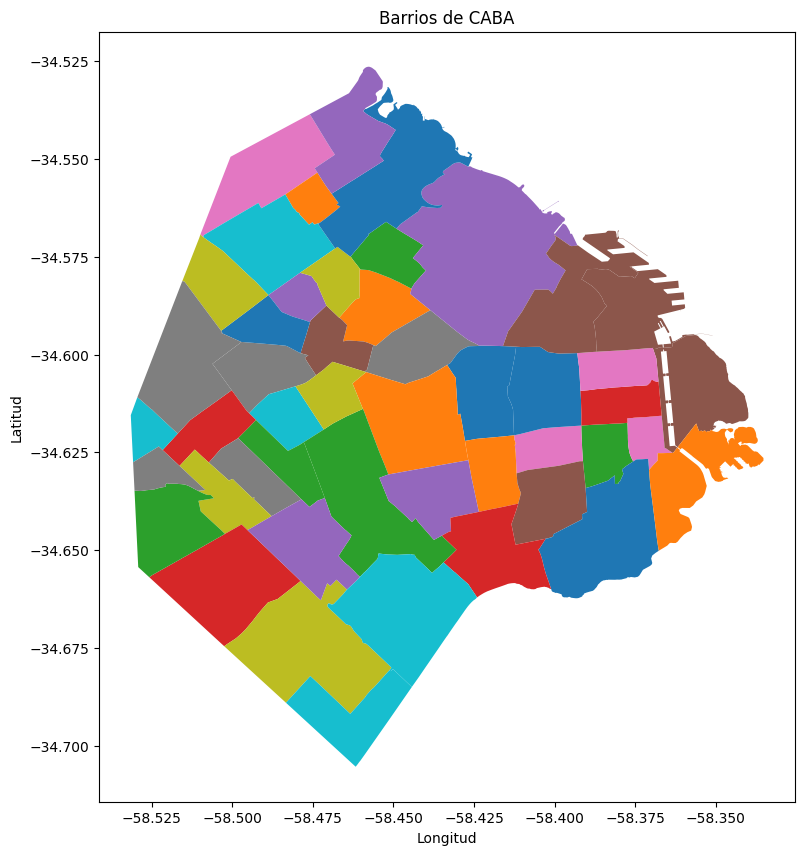

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_title('Barrios de CABA')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
poligonos.plot(ax=ax,column='BARRIO')

Se descartan las coordenadas NaNs ya que no son el objetivo de esta ocasión y creamos otro data frame que contenga las filas con ciudades NaN.

In [56]:
ds_copia = ds_properati.copy()

ds_ciudades_nan = ds_copia.loc[(ds_copia["ciudad"].isna()) & (ds_copia["latitud"].isna()==False) & (ds_copia["longitud"].isna()==False)]
ds_ciudades_nan.head(3)

,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
600,2021-02-20,-31.678900,-63.879640,Capital Federal,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,USD
1261,2021-02-09,-34.581285,-58.469703,Capital Federal,NaN,Venta,PH,3.0,NaN,198.0,94.0,268000.0,USD
1337,2021-02-09,-34.606577,-58.449072,Capital Federal,NaN,Venta,Departamento,2.0,NaN,52.0,50.0,127000.0,USD


In [57]:
display(ds_ciudades_nan.ciudad.unique())
display(ds_ciudades_nan.ciudad.isna().sum())

array([nan], dtype=object)

247

Todas las ciudades (247) son NaN

Creamos una geometría de punto para el par longitud y latitud. 

In [58]:
points = gp.GeoDataFrame(ds_ciudades_nan, geometry=gp.points_from_xy(ds_ciudades_nan.longitud, ds_ciudades_nan.latitud))
points.head(3)

,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,geometry
600,2021-02-20,-31.678900,-63.879640,Capital Federal,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,USD,POINT (-63.87964 -31.67890)
1261,2021-02-09,-34.581285,-58.469703,Capital Federal,NaN,Venta,PH,3.0,NaN,198.0,94.0,268000.0,USD,POINT (-58.46970 -34.58129)
1337,2021-02-09,-34.606577,-58.449072,Capital Federal,NaN,Venta,Departamento,2.0,NaN,52.0,50.0,127000.0,USD,POINT (-58.44907 -34.60658)


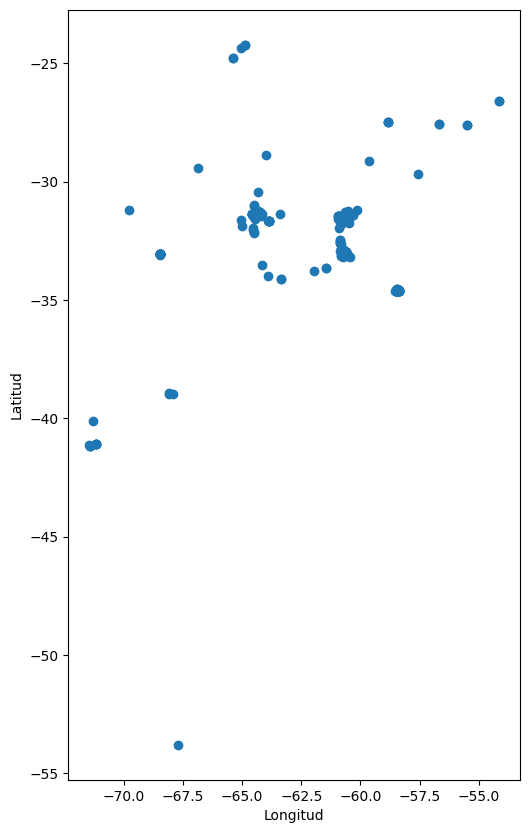

In [59]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

poligonos.plot(ax=ax,column='BARRIO',alpha=0.5) #ver por q no se muestra
points.plot(ax=ax) 
plt.show()

In [60]:
for barrio in poligonos.BARRIO:
    b = poligonos[poligonos['BARRIO'] == barrio].index[0] #obtengo el indice del barrio en el df

    #creo un vector true/false si la propiedad está en el barrio (interseccion punto con poligono)
    mask = points.within(poligonos.loc[b, 'geometry']) 
    points.loc[mask,"ciudad"] = barrio
points.head()

,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,geometry
600,2021-02-20,-31.678900,-63.879640,Capital Federal,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,USD,POINT (-63.87964 -31.67890)
1261,2021-02-09,-34.581285,-58.469703,Capital Federal,VILLA ORTUZAR,Venta,PH,3.0,NaN,198.0,94.0,268000.0,USD,POINT (-58.46970 -34.58129)
1337,2021-02-09,-34.606577,-58.449072,Capital Federal,VILLA CRESPO,Venta,Departamento,2.0,NaN,52.0,50.0,127000.0,USD,POINT (-58.44907 -34.60658)
1740,2021-05-18,-33.081030,-68.468140,Capital Federal,NaN,Venta,Departamento,3.0,2.0,66.0,60.0,80000.0,USD,POINT (-68.46814 -33.08103)
1741,2021-05-18,-31.390431,-64.179004,Capital Federal,NaN,Venta,Departamento,1.0,NaN,NaN,38.0,55000.0,USD,POINT (-64.17900 -31.39043)


In [61]:
display(points.ciudad.isna().sum())
display(points.ciudad.unique())

196

array([nan, 'VILLA ORTUZAR', 'VILLA CRESPO', 'FLORESTA', 'BALVANERA',
       'SAN CRISTOBAL', 'FLORES', 'ALMAGRO', 'RECOLETA', 'VILLA URQUIZA',
       'PALERMO', 'SAN NICOLAS', 'VILLA DEVOTO', 'BELGRANO', 'VILLA LURO',
       'CABALLITO', 'PARQUE PATRICIOS', 'COLEGIALES', 'VILLA SANTA RITA',
       'BOEDO', 'MONTE CASTRO', 'COGHLAN', 'AGRONOMIA'], dtype=object)

Vemos que 51 ciudades (247-196) encontraron coincidencia en algún polígono y se les imputó su barrio correspondiente.
Finalmente volcamos los resultados en el data set original.

In [62]:
ds_ciudades_nan.drop("geometry", axis=1)
ds_properati.loc[ds_ciudades_nan.index] = ds_ciudades_nan 
ds_properati

,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD
1,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD
2,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD
3,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD
4,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94244,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,Venta,Departamento,4.0,3.0,130.0,100.0,220000.0,USD
94245,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,Venta,Departamento,3.0,2.0,68.0,60.0,161000.0,USD
94246,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,1.0,51.0,30.0,75500.0,USD
94247,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,1.0,37.0,31.0,74500.0,USD


In [63]:
ds_properati["ciudad"].isna().sum()

366

Pasamos de tener 417 ciudades NaN a tener 366. Las que no pudieron ser reemplazadas o bien tienen latitud y longitud NaN (por lo que no pudimos imputar el barrio) o no son de CABA. Entonces, las eliminamos porque no son de interés.

In [64]:
ds_properati = ds_properati.loc[(ds_properati["ciudad"].isna() == False)]
display(ds_properati["ciudad"].isna().sum())
ds_properati.reset_index(drop=True, inplace=True)
ds_properati.head()

0

,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD
1,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD
2,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD
3,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD
4,2021-09-09,-34.623886,-58.412746,Capital Federal,Boedo,Venta,PH,2.0,1.0,61.0,46.0,100000.0,USD


<AxesSubplot: title={'center': 'Frecuencia de valores de la variable ciudad luego de la imputación'}, xlabel='frecuencia', ylabel='zona'>

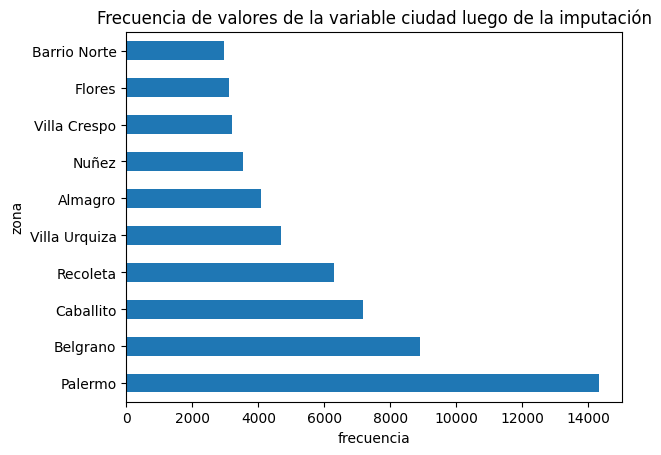

In [65]:
ds_agrupado_PL_3[:10].plot(kind = "barh", title="Frecuencia de valores de la variable ciudad luego de la imputación", xlabel="frecuencia",ylabel="zona")

De la misma manera, vamos a tomar las observaciones que tienen ciudad pero no coordenadas para imputarlas.

In [66]:

print(ds_properati[ds_properati["longitud"].isnull()].size) 
print(ds_properati[ds_properati["latitud"].isnull()].size)

46280
46280


En todos los casos donde *latitud* es null también lo es *longitud*, por lo tanto filtramos por ambas coordenadas NaN y ciudad existente y agregamos la longitud/ latitud segun la ubicacion de la ciudad .

In [87]:
import pyproj

In [97]:
ds_copia = ds_properati.copy()
ds_coord_nan = ds_copia.loc[(ds_copia["ciudad"].isna() == False) & (ds_copia["latitud"].isna()) & (ds_copia["longitud"].isna())]

# poligonos["centroid"] = poligonos["geometry"].centroid

# for index, row in ds_coord_nan.iterrows():
#     ciudad = row["ciudad"]
#     poligono = poligonos.loc[poligonos['BARRIO'] == ciudad]

#     # row["latitud"] = centroide[0] #obtengo el indice del barrio en el df
#     # row["longitud"] = centroide[1]

   

/tmp/ipykernel_12265/3255784589.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poligonos["centroid"] = poligonos["geometry"].centroid


GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([], Name: centroid, dtype: geometry)
GeoSeries([],

Siguiendo los datos faltantes, para las columnas de property rooms tomamos la opción 2 para tratar dichos datos como categoría extra, describiendolos con el -1 representando como no reportados.

In [68]:
ds_properati['property_rooms'] = ds_properati['property_rooms'].fillna("Ambientes no reportados")

/tmp/ipykernel_12265/142448675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_properati['property_rooms'] = ds_properati['property_rooms'].fillna("Ambientes no reportados")


Podriamos imputar los valores nans de la categoria bedrooms tomando en cuenta la media de cada uno de los diferentes ambientes (10 ambientes en total)

In [69]:
medias = []
repeticiones = 0
for cant in range(1,11):
    ds_copia = ds_properati.copy()
    copia_con_cant_ambientes = ds_copia.loc[ds_copia["property_rooms"]==cant]
    medias.append(round(copia_con_cant_ambientes["property_bedrooms"].mean()))
    
medias

[1, 1, 2, 3, 4, 4, 4, 5, 5, 6]

Como ya tenemos la media de las habitaciones por cada ambientes, procedemos a imputarlas

In [70]:
prop_nan = ds_properati.loc[ds_properati["property_bedrooms"].isna()]

for index,row in prop_nan.iterrows():

    cantidad = row["property_rooms"]
    if  cantidad != "Ambientes no reportados" and cantidad < 11:
        row["property_bedrooms"] = medias[int(cantidad)-1]
        

ds_properati.loc[prop_nan.index] = prop_nan


Para las columnas de property_surface_total y property_surface_covered adquirimos la estategia de la opcion 3 adoptando la media de sus valores totales no faltantes:

In [71]:
prop_surface_total_antes = ds_properati["property_surface_total"]
prop_surface_covered_antes = ds_properati["property_surface_covered"]
ds_properati["property_surface_total"] = ds_properati['property_surface_total'].fillna(ds_properati['property_surface_total'].mean())
ds_properati["property_surface_covered"] = ds_properati['property_surface_covered'].fillna(ds_properati['property_surface_covered'].mean())
ds_properati

/tmp/ipykernel_12265/1410702004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_properati["property_surface_total"] = ds_properati['property_surface_total'].fillna(ds_properati['property_surface_total'].mean())
/tmp/ipykernel_12265/1410702004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_properati["property_surface_covered"] = ds_properati['property_surface_covered'].fillna(ds_properati['property_surface_covered'].mean())


,created_on,latitud,longitud,provincia,ciudad,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency
0,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Venta,Departamento,3.0,2.0,58.000000,55.0,82900.0,USD
1,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Venta,Departamento,4.0,3.0,70.000000,70.0,99000.0,USD
2,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Venta,Departamento,4.0,2.0,107.633408,104.0,146000.0,USD
3,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Venta,PH,4.0,2.0,107.633408,73.0,250000.0,USD
4,2021-09-09,-34.623886,-58.412746,Capital Federal,Boedo,Venta,PH,2.0,1.0,61.000000,46.0,100000.0,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93878,2021-01-05,-34.603245,-58.489810,Capital Federal,Villa del Parque,Venta,Departamento,4.0,3.0,130.000000,100.0,220000.0,USD
93879,2021-01-05,-34.614063,-58.482814,Capital Federal,Villa del Parque,Venta,Departamento,3.0,2.0,68.000000,60.0,161000.0,USD
93880,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,1.0,51.000000,30.0,75500.0,USD
93881,2021-01-05,-34.614175,-58.479062,Capital Federal,Villa del Parque,Venta,Departamento,1.0,1.0,37.000000,31.0,74500.0,USD


Ahora podemos ver como queda el porcentaje de valores nans respecto del total de la database

In [72]:
porcentajes = ds_properati.isna().sum() / len(ds_properati) * 100
porcentajes

created_on                   0.000000
latitud                      3.791954
longitud                     3.791954
provincia                    0.000000
ciudad                       0.000000
operation                    0.000000
property_type                0.000000
property_rooms               0.000000
property_bedrooms           11.619782
property_surface_total       0.000000
property_surface_covered     0.000000
property_price               0.000000
property_currency            0.000000
dtype: float64

Podemos mostrar como quedan los datos antes y despues de las imputaciones, como por ejemplo los casos de property_surface_total o property_surface_covered

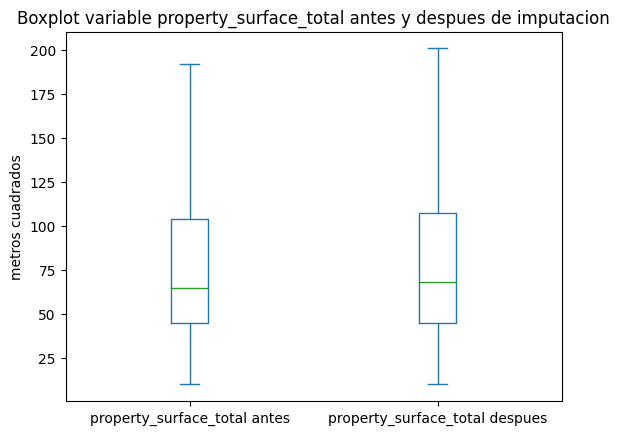

In [73]:
df_comparado = pd.DataFrame({"property_surface_total antes":prop_surface_total_antes,"property_surface_total despues":ds_properati['property_surface_total']})
ax = df_comparado[["property_surface_total antes","property_surface_total despues"]].plot(kind= "box",title="Boxplot variable property_surface_total antes y despues de imputacion",showfliers=False,ylabel="metros cuadrados")
plt.show()


Se puede ver que removiendo los outliers, queda un boxplot parecido ya que estamos hallando la media de todos los valores. Igualmente si inspeccionamos minusiosamente, podemos ver que el gráfico de la derecha se encuentra mas grande. Pero se podría decir que no cambia mayormente la distribución de los datos tomando la media para los datos faltantes.

Lo mismo se podria decir para el caso de property_surface_covered al agregar los datos faltantes por la media de los datos no faltantes.

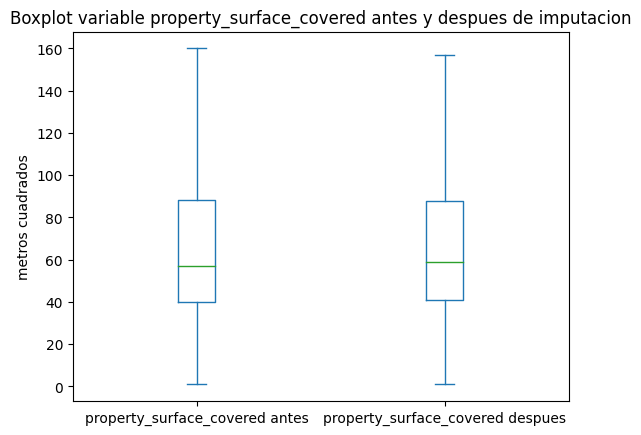

In [74]:
df_comparado = pd.DataFrame({"property_surface_covered antes":prop_surface_covered_antes,"property_surface_covered despues":ds_properati['property_surface_covered']})
ax = df_comparado[["property_surface_covered antes","property_surface_covered despues"]].plot(kind= "box",title="Boxplot variable property_surface_covered antes y despues de imputacion",showfliers=False,ylabel="metros cuadrados")
plt.show()

#### Busqueda Valores Atípicos - Univariados


Haciendo de un boxplot se hace el analisis de valores atipicos en forma univariada

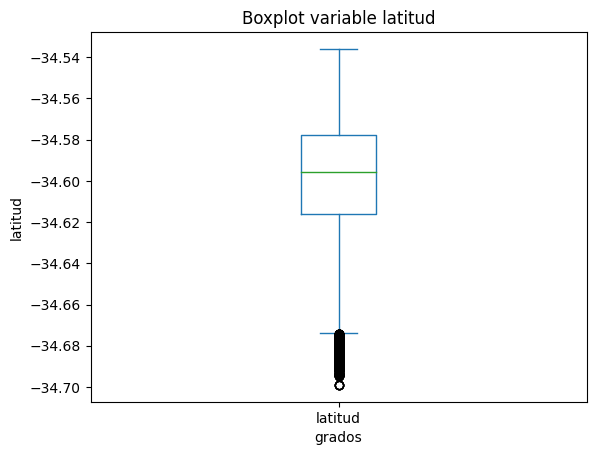

In [75]:
#Valores atipicos en la latitud:
ds_properati['latitud'].plot.box(title="Boxplot variable latitud",xlabel="grados",ylabel="latitud")  #medio feucho el gráfico q genera esto, no?
plt.show()

Como se puede observar, la abrumadora mayoría de propiedades en venta se encuentran sobre una latitud sur de alrededor de 34º, lo cual coincide con la ubicación geográfica de la Ciudad Autónoma de Buenos Aires. Todo valor que se aleje, aunque sea en un par de grados, puede ser considerado un outlier ya que Capital Federal se encuentra a ≈34.6º latitud sur.

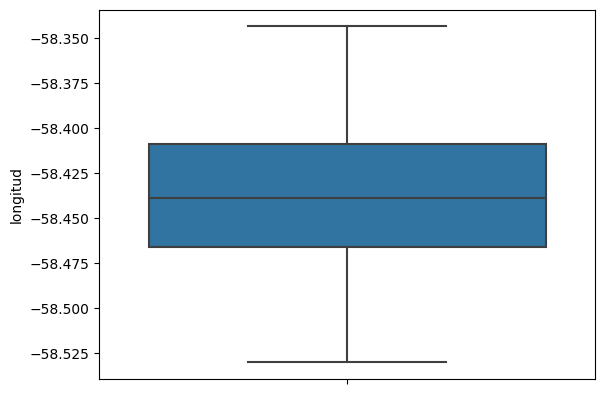

In [76]:
#Boxplot de la variable longitud
sns.boxplot(y=ds_properati.longitud)
plt.show()

Lo mismo sucede con la longitud. La Ciudad Autónoma de Buenos Aires se encuentra a una longitud oeste de ≈58.43º, lo cual coincide con la gran mayoría de datos (comparando con el boxplot). Es por esto que cualquier entrada que se aleje de este valor puede ser considerado un outlier.

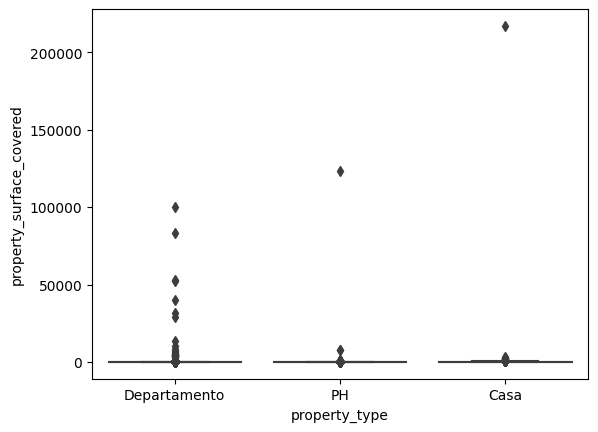

In [77]:
#Boxplot de la variable property_surface_covered

sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_covered)
plt.show()

Antes de proceder al análisis, se eliminan outliers claros los cuales pueden tener una repercusión en el cálculo del z-score. Se toma un valor arbitrario de 5000m², lo cual equivale a media manzana.

In [78]:
ds_properati.drop(ds_properati[ds_properati['property_surface_covered'] >= 5000].index, inplace=True)

/tmp/ipykernel_12265/1783733402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_properati.drop(ds_properati[ds_properati['property_surface_covered'] >= 5000].index, inplace=True)


Analizando los potenciales outliers para cada uno de los tipos de propiedad haciendo uso del z-score modificado.

In [79]:
casa = ds_properati[ds_properati['property_type'] == "Casa"]
dpto = ds_properati[ds_properati['property_type'] == "Departamento"]
ph = ds_properati[ds_properati['property_type'] == "PH"]

#Cuartiles
Q1_sup_cubierta_casa = np.quantile(casa['property_surface_covered'], 0.25)
Q3_sup_cubierta_casa = np.quantile(casa['property_surface_covered'], 0.75)

Q1_sup_cubierta_dpto = np.quantile(dpto['property_surface_covered'], 0.25)
Q3_sup_cubierta_dpto = np.quantile(dpto['property_surface_covered'], 0.75)

Q1_sup_cubierta_ph = np.quantile(ph['property_surface_covered'], 0.25)
Q3_sup_cubierta_ph = np.quantile(ph['property_surface_covered'], 0.75)

#Rango intercuartil
IQR_sup_cubierta_casa = Q3_sup_cubierta_casa - Q1_sup_cubierta_casa
IQR_sup_cubierta_dpto = Q3_sup_cubierta_dpto - Q1_sup_cubierta_dpto
IQR_sup_cubierta_ph = Q3_sup_cubierta_ph - Q1_sup_cubierta_ph

#Límite inferior
out_inf_casa = Q1_sup_cubierta_casa - 1.5 * IQR_sup_cubierta_casa
out_sup_casa = Q3_sup_cubierta_casa + 1.5 * IQR_sup_cubierta_casa

out_inf_dpto = Q1_sup_cubierta_dpto - 1.5 * IQR_sup_cubierta_dpto
out_sup_dpto = Q3_sup_cubierta_dpto + 1.5 * IQR_sup_cubierta_dpto

out_inf_ph = Q1_sup_cubierta_ph - 1.5 * IQR_sup_cubierta_ph
out_sup_ph = Q3_sup_cubierta_ph + 1.5 * IQR_sup_cubierta_ph

#Z-Score modificado
mediana_sup_cubierta_casa = np.median(casa['property_surface_covered'])
MAD = np.median(np.absolute(casa['property_surface_covered'] - mediana_sup_cubierta_casa))
casa['zm_sup_cubierta'] = (casa['property_surface_covered'] - mediana_sup_cubierta_casa) * 0.6745 / MAD

mediana_sup_cubierta_dpto = np.median(dpto['property_surface_covered'])
MAD = np.median(np.absolute(dpto['property_surface_covered'] - mediana_sup_cubierta_dpto))
dpto['zm_sup_cubierta'] = (dpto['property_surface_covered'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD

mediana_sup_cubierta_ph = np.median(ph['property_surface_covered'])
MAD = np.median(np.absolute(ph['property_surface_covered'] - mediana_sup_cubierta_ph))
ph['zm_sup_cubierta'] = (ph['property_surface_covered'] - mediana_sup_cubierta_ph) * 0.6745 / MAD

/tmp/ipykernel_12265/2176088885.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casa['zm_sup_cubierta'] = (casa['property_surface_covered'] - mediana_sup_cubierta_casa) * 0.6745 / MAD
/tmp/ipykernel_12265/2176088885.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dpto['zm_sup_cubierta'] = (dpto['property_surface_covered'] - mediana_sup_cubierta_dpto) * 0.6745 / MAD
/tmp/ipykernel_12265/2176088885.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

A continuación se puede observar una gran cantidad de departamentos que son considerados outliers siguiendo la regla de oro de z-score modificado (z-score >= 3.5), con algunos cientos en casas y PHs.

In [80]:
print(casa[casa['zm_sup_cubierta'] >= 3.5].shape)
print(dpto[dpto['zm_sup_cubierta'>= 3.5shape)
)
print(ph[ph['zm_sup_cubierta'>= 3.5].shape)


SyntaxError: invalid decimal literal (1297288715.py, line 2)

Eliminando aquellos valores que son outliers.

In [ ]:
ds_properati.drop(casa[casa['zm_sup_cubierta'] >= 3.5.5].index, inplace = True)
ds_properati.drop(dpto[dpto['zm_sup_cubierta'] >=.5.5].index, inplace = True)
ds_properati.drop(ph[ph['zm_sup_cubierta'] >=.5.5].index, inplace = Trux)

KeyError: '[1317, 1318, 1710, 1712, 1713, 2381, 4391, 4826, 6680, 8106, 9441, 10427, 11602, 11670, 12065, 13235, 14118, 14657, 14750, 15787, 16276, 16371, 16925, 17775, 18157, 18739, 18741, 18750, 18756, 21113, 22144, 22166, 22259, 22572, 23000, 23903, 25289, 25532, 25588, 27048, 27129, 27132, 27465, 27840, 27842, 27851, 28638, 28792, 28793, 30140, 30370, 30799, 30803, 31654, 32189, 32297, 33543, 33969, 33970, 33973, 33974, 34763, 34764, 36387, 36395, 36397, 36898, 37202, 37203, 37850, 39695, 40395, 42606, 42909, 43119, 43283, 43561, 43877, 45211, 45545, 45576, 45873, 46479, 46480, 46481, 46747, 47125, 47776, 48359, 49140, 49551, 49599, 49709, 50757, 50913, 51999, 52959, 53461, 53869, 54674, 55174, 55973, 55975, 56729, 56731, 57185, 57527, 58223, 58535, 59323, 59427, 60313, 60702, 60858, 61338, 61352, 61395, 61398, 61402, 61405, 62077, 62082, 62935, 63683, 64720, 65130, 65457, 65460, 65745, 66424, 66797, 67336, 67411, 67609, 67712, 69062, 69818, 70645, 70875, 71034, 71428, 71647, 72097, 72098, 72485, 72492, 72825, 73229, 73645, 73698, 73886, 74090, 74253, 74298, 74885, 74988, 75902, 76383, 76749, 77399, 78101, 78102, 78137, 78378, 78713, 78809, 78905, 79492, 79522, 81922, 82286, 82293, 82645, 84560, 85202, 85935, 86143, 87692, 89892, 90891, 91266, 92269, 93534, 93535] not found in axis'

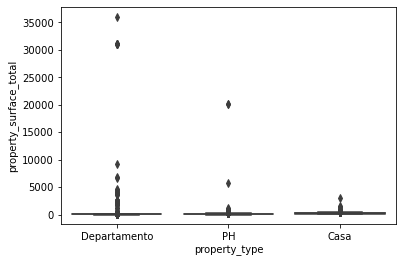

In [ ]:
#Boxplot de la variable property_surface_total
sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_total)
plt.show()

Como se puede observar, hay valores de superficie extremadamente grandes, que no solo no coinciden con la mayoría de entradas, sino que resultan inconcebibles para una propiedad en Capital Federal. Además, estos valores atípicos estiran el eje y del gráfico, resultando en que la mayoría de valores caigan cerca del 0. Una vez que estos valores atípicos sean corregidos, se volverá a graficar este box plot para ver la diferencia.

Para la superficie cubierta y total de las propiedades, se realiza la comparación respecto a los distintos tipos de propiedad por separado. Esto se debe a que las superficies esperables para una casa son mucho mayores que para un departamento, por ejemplo.

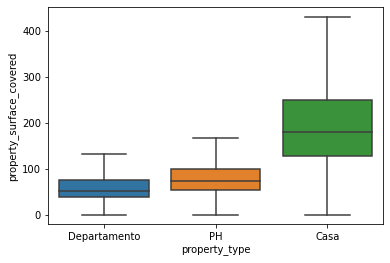

In [ ]:
#Boxplot de la variable property_surface_covered

sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_covered, showfliers = False)
plt.show()

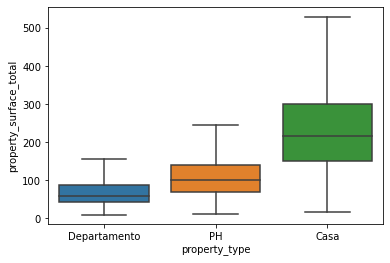

In [ ]:
#Boxplot de la variable property_surface_total

sns.boxplot(x=ds_properati.property_type, y=ds_properati.property_surface_total, showfliers = False)
plt.show()

Como se puede observar, para el caso de superficie cubierta en departamentos, PHs y casas, las entradas dejan de ser consideradas outliers en valores de aproximadamente 160m², 180m², y 440m², respectivamente. En cuanto a la superficie total, los valores son de 190m², 260m² y 580m².

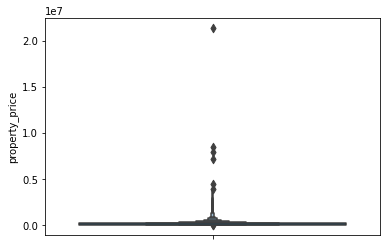

In [ ]:
#Boxlot de la variable property_price
sns.boxenplot(y=ds_properati.property_price)
plt.show()

Aplicando el mismo concepto para el precio de las propiedades...

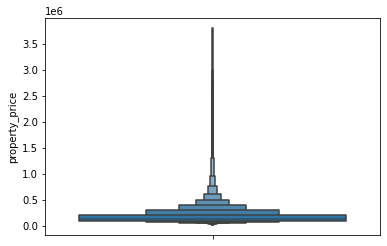

In [ ]:
#Boxlot de la variable property_price
sns.boxenplot(y=ds_properati.property_price, showfliers = False)
plt.show()

Como se puede apreciar en esta ocasión, un buen punto de corte para el precio de las propiedades parece ser en 3.500.000 USD, lo cual es un valor relativamente alto, pero factible.

Graficando en un histograma la distribución de la cantidad de ambientes, se puede apreciar que una ínfima cantidad de propiedades supera los 10 ambientes, con un gran número de propiedades teniendo una cantidad de ambientes entre 1 y 4.

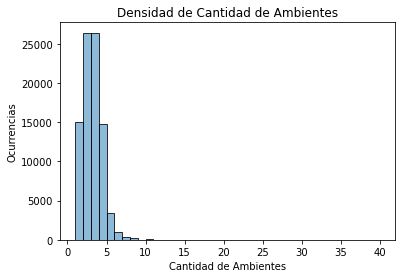

In [ ]:
aux = ds_properati[ds_properati['property_rooms'] != "Ambientes no reportados"]

sns_hist = sns.histplot(data=aux['property_rooms'], alpha = 0.5, binwidth=1).set(title="Densidad de Cantidad de Ambientes",xlabel="Cantidad de Ambientes",ylabel="Ocurrencias")

Aca podemos actualizar el dataframe eliminando los outliers 

#### Busqueda Valores Atípicos - Multivariado

Haciendo el analisis de los datos faltantes pudimos identificar a todos los registros donde su latitud y longitud no era correcta, por lo que no se encontrarian outliers en esas dos categorias.

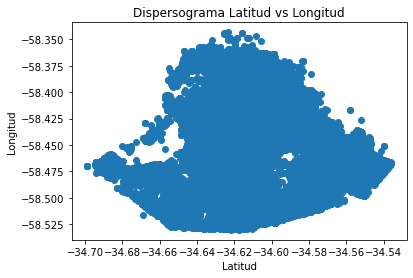

In [ ]:
plt.scatter(ds_properati.latitud, ds_properati.longitud)
plt.title('Dispersograma Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

Como es de esperarse, la abrumadora mayoría de puntos se hallan alrededor 

Analizamos los outliers multivariados de las categorias Property rooms y Precio.

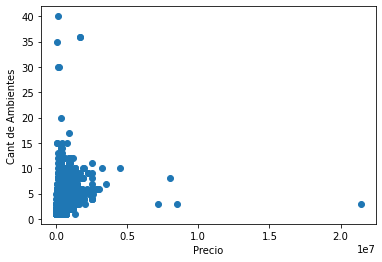

In [ ]:
aux = ds_properati[ds_properati['property_rooms'] != "Ambientes no reportados"]

plt.scatter(aux.property_price, aux.property_rooms)
plt.xlabel('Precio')
plt.ylabel('Cant de Ambientes')
plt.show()

Se puede ver que hay algunos valores que se encuentran muy por arriba de la media, asi que procedemos a analizarlos con el metodo de Isolation Forest.

In [ ]:
from scipy.spatial import distance

aux_1 = aux[["property_price","property_rooms"]]

display(aux_1.loc[[87562]])

aux_1["mahalnobis"] =  distance.mahalanobis(aux["property_price"], aux["property_rooms"], aux_1.cov())
aux_1

,property_price,property_rooms
87562,87000.0,2.0


/tmp/ipykernel_7204/4164201716.py:7: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  aux_1["mahalnobis"] =  distance.mahalanobis(aux["property_price"], aux["property_rooms"], aux_1.cov())


ValueError: shapes (87562,) and (1,1) not aligned: 87562 (dim 0) != 1 (dim 0)

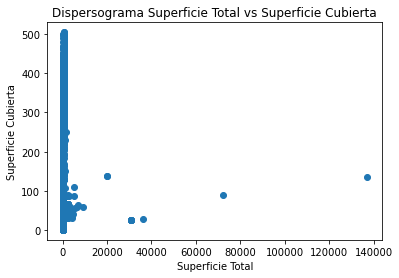

In [ ]:
plt.scatter(ds_properati.property_surface_total, ds_properati.property_surface_covered)
plt.title('Dispersograma Superficie Total vs Superficie Cubierta')
plt.xlabel('Superficie Total')
plt.ylabel('Superficie Cubierta')
plt.show()

In [ ]:
aux = ds_properati[["property_surface_total","property_surface_covered"]]


aux["mahalnobis"] =  distance.mahalanobis(aux["property_surface_total"], aux["property_surface_covered"], aux.cov())

ValueError: shapes (65454,) and (2,2) not aligned: 65454 (dim 0) != 2 (dim 0)

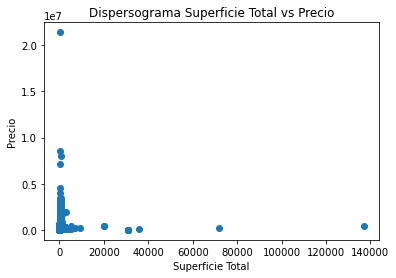

In [ ]:
plt.scatter(ds_properati.property_surface_total, ds_properati.property_price)
plt.title('Dispersograma Superficie Total vs Precio')
plt.xlabel('Superficie Total')
plt.ylabel('Precio')
plt.show()

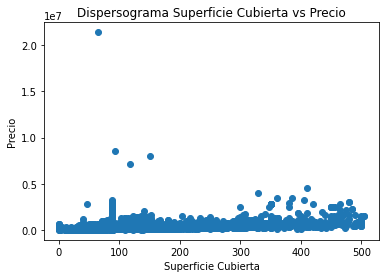

In [ ]:
#property_surface_covered-propery_price
plt.scatter(ds_properati.property_surface_covered, ds_properati.property_price)
plt.title('Dispersograma Superficie Cubierta vs Precio')
plt.xlabel('Superficie Cubierta')
plt.ylabel('Precio')
plt.show()

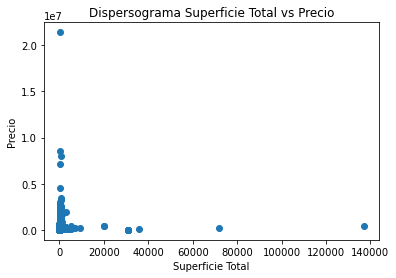

In [ ]:
aux1 = ds_properati[ds_properati['property_type'] == "Departamento"]
aux2 = ds_properati[ds_properati['property_type'] == "PH"]
aux3 = ds_properati[ds_properati['property_type'] == "Casa"]

plt.scatter(aux.property_surface_total, aux.property_price)
plt.title('Dispersograma Superficie Total vs Precio')
plt.xlabel('Superficie Total')
plt.ylabel('Precio')
plt.show()


#graf_relplot = sns.relplot(data=aux,x="property_surface_total", y="property_surface_covered", hue="property_type",palette=["r", "g", "b"]).set(title="Sup Total vs Cubierta",xlabel='Total',ylabel='Cubierta')

### Reducción de la dimensionalidad

Como podemos ver en el grafico de correlacion, las unicas dos categorias que se encuentran lo suficientemente correlacionadas para aplicarle el algoritmo de reduccion de la dimensionalidad son property_surface_covered y property_surface_total.

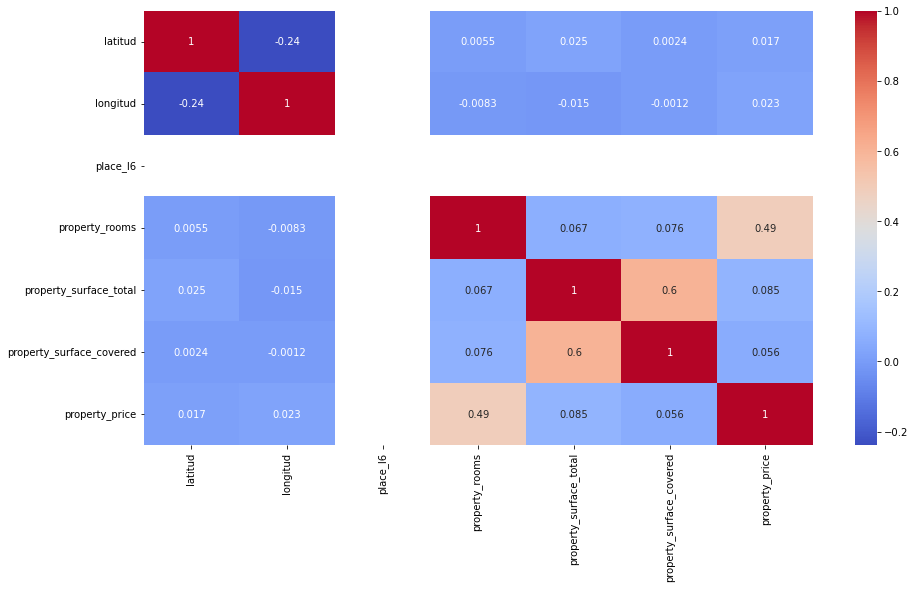

In [ ]:
plt.figure(figsize = (15,8))
display(sns.heatmap(matriz_corr, annot = True, cmap='coolwarm'))

Importamos las librerias a utilizar

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
columnas_elegidas = ["property_surface_total","property_surface_covered"]
x = ds_properati[columnas_elegidas].values
x = StandardScaler().fit_transform(x)

En principio le ponemos 4 componentes para hallar la matriz de covarianza

In [ ]:
pca = PCA(n_components=2) ##Porque tenemos 2 componentes solamente
x_transformada = pca.fit_transform(x)

In [ ]:
pca_df_aux = pd.DataFrame(data = x_transformada, columns = ['cp_1', 'cp_2'])

In [ ]:
pca.explained_variance_ratio_

array([0.54178358, 0.45821642])

In [ ]:
pca.get_covariance()

array([[1.00001528, 0.1547032 ],
       [0.1547032 , 1.00001528]])

Exportamos el último data set para usarlo durante el otro tramo del TP


In [ ]:
ds_properati.to_csv("nueva_database_properati.csv")

In [ ]:
ds_properaty_reducido = pd.read_csv("nueva_database_properati.csv")
ds_properati_nuevo = ds_properaty_reducido.copy() #copia  

### Agrupamiento


Se nos pide analizar si es posible agrupar los datos en función de algún criterio. Para esto, utilizamos el algoritmo K-Means

Importamos las librerias que vamos a usar

In [ ]:
!pip install pyclustertend
from pyclustertend import hopkins

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

  Using cached pyclustertend-1.8.0-py3-none-any.whl (7.2 kB)
  Using cached matplotlib-3.6.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached numba-0.54.1-cp38-cp38-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.3 MB)
  Using cached scikit_learn-1.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached fonttools-4.37.4-py3-none-any.whl (960 kB)
  Using cached contourpy-1.0.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (295 kB)
  Using cached llvmlite-0.37.0-cp38-cp38-manylinux2014_x86_64.whl (26.3 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.33.0+1.g022ab0f
ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


ModuleNotFoundError: No module named 'pyclustertend'

En primer lugar analizamos la tendencia al clustering del dataset

In [ ]:
hopkins(ds_properati_nuevo,ds_properati_nuevo.shape[0])

NameError: name 'hopkins' is not defined

Para el método de inicialización (init) lo definimos en random para que los puntos se seleccionen aleatoriamente

Para el número de clusters 4


In [ ]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(ds_properati_nuevo)

y_kmeans = kmeans.predict(ds_properati_nuevo)

ValueError: could not convert string to float: '2021-09-09'